# Conexión con BigQuery

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
project_id = "bq-project-418519"

credentials = service_account.Credentials.from_service_account_file(
    "bq-project-418519-a392272e58f9.json",
)

client = bigquery.Client(project=project_id, credentials=credentials)

## Parte 2.4.1

In [14]:
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt

In [10]:
query = '''
WITH venta_fruta AS (
  SELECT fruta, mes,region, SUM(cantidad) AS ventas_totales
  FROM `tarea1.ordenes`
  GROUP BY region, mes, fruta
)
SELECT region, mes, fruta, venta_fruta.ventas_totales
FROM venta_fruta
ORDER BY venta_fruta.region, venta_fruta.mes
'''

In [11]:
df = pandas_gbq.read_gbq(query, dialect='standard', project_id=project_id)

c:\Users\titok\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:2257: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [13]:
df

,region,mes,fruta,ventas_totales
0,1,1,kiwi,423
1,1,1,limon,1993
2,1,1,melon,3792
3,1,1,manzana,537
4,1,1,naranja,1185
...,...,...,...,...
115,2,12,kiwi,6212
116,2,12,limon,9090
117,2,12,melon,8435
118,2,12,manzana,8105


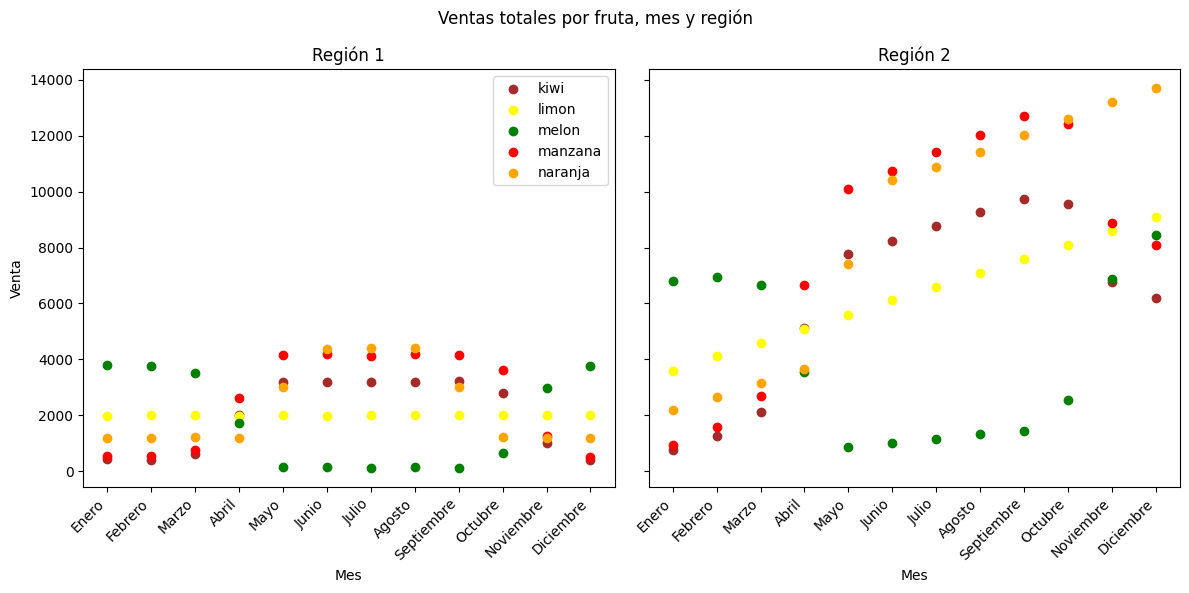

In [32]:
import matplotlib.pyplot as plt

meses_dict = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
              7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}

colors = {'kiwi': 'brown', 'limon': 'yellow', 'melon': 'green', 'manzana': 'red', 'naranja': 'orange'}

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

for i, region in enumerate(df['region'].unique(), 1):
    ax = axs[i-1]
    
    subset = df[df['region'] == region]
    
    for fruta in subset['fruta'].unique():
        fruta_data = subset[subset['fruta'] == fruta]
        ax.scatter(fruta_data['mes'], fruta_data['ventas_totales'], label=fruta, color=colors.get(fruta, 'blue'))

    ax.set_title(f'Región {region}')    
    ax.set_xlabel('Mes')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([meses_dict[mes] for mes in range(1, 13)], rotation=45, ha='right')

axs[0].set_ylabel('Venta')
axs[0].legend()
fig.suptitle('Ventas totales por fruta, mes y región')
plt.tight_layout()
plt.show()




# Parte 2.4.2

In [33]:
query = '''
WITH ventas_dia AS (
  SELECT U.region, U.mes, U.dia, SUM(P._precio*O.cantidad) AS ingresos_dia FROM  `tarea1.usuarios_ordenes` U
  JOIN `tarea1.ordenes` O ON (U.compra_id=O.orden_id and U.mes=O.mes)
  JOIN `tarea1.precios` P ON (P.fruta = O.fruta)
  GROUP BY U.region, U.mes, U.dia
  ORDER BY U.region, U.mes, U.dia
)
SELECT *,
  SUM(ingresos_dia) OVER (
    PARTITION BY region ORDER BY mes, dia ASC
    RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS cumulative_sum
FROM ventas_dia
'''

In [34]:
df = pandas_gbq.read_gbq(query, dialect='standard', project_id=project_id)

c:\Users\titok\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:2257: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [40]:
df[(df['mes'] == 12) & (df['dia'] == 31)]

,region,mes,dia,ingresos_dia,cumulative_sum
364,1,12,31,77950,37436200
729,2,12,31,241950,71889550


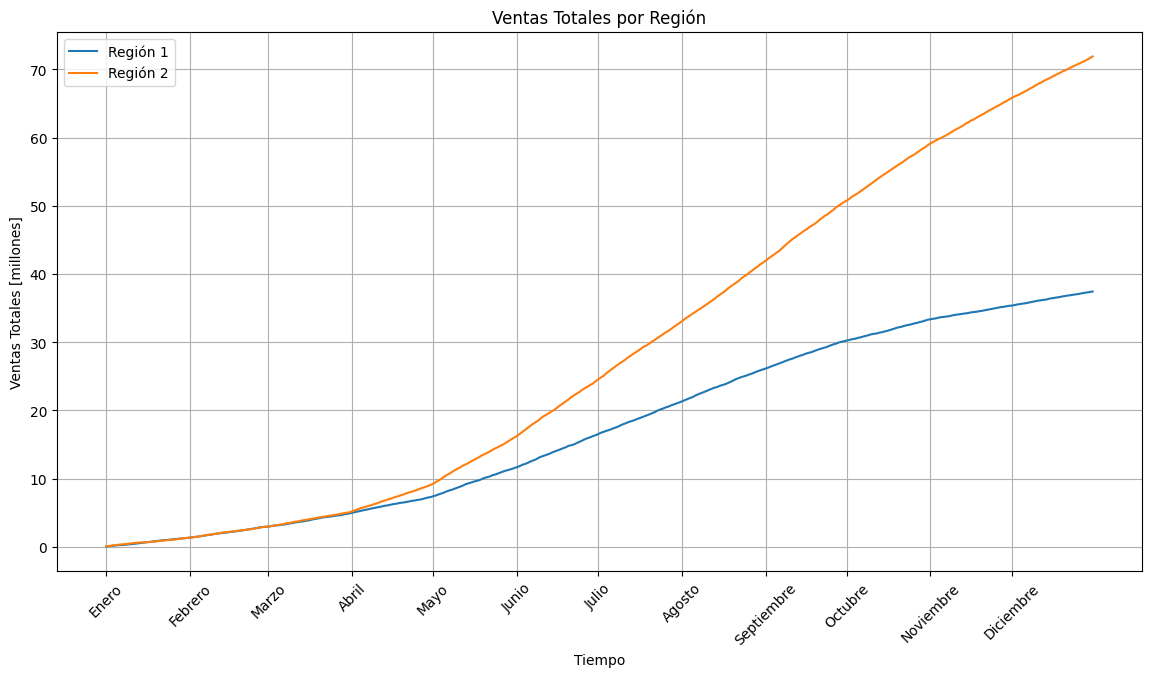

In [50]:
df['fecha'] = pd.to_datetime('2024-' + df['mes'].astype(str) + '-' + df['dia'].astype(str))

ventas_totales = df.groupby(['region', 'fecha'])['ingresos_dia'].sum().reset_index()

month_names_spanish = {
    'January': 'Enero',
    'February': 'Febrero',
    'March': 'Marzo',
    'April': 'Abril',
    'May': 'Mayo',
    'June': 'Junio',
    'July': 'Julio',
    'August': 'Agosto',
    'September': 'Septiembre',
    'October': 'Octubre',
    'November': 'Noviembre',
    'December': 'Diciembre'
}

fig, ax = plt.subplots(figsize=(14, 7))

for region, datos_region in ventas_totales.groupby('region'):
    ax.plot(datos_region['fecha'], datos_region['ingresos_dia'].cumsum() / 1e6, label=f'Región {region}')  # Scale to millions

ax.set_xlabel('Tiempo')
ax.set_ylabel('Ventas Totales [millones]')
ax.set_title('Ventas Totales por Región')

# Setting x-axis tick labels to Spanish
ax.set_xticks(datos_region['fecha'][datos_region['fecha'].dt.day == 1])
ax.set_xticklabels([month_names_spanish[month] for month in datos_region['fecha'][datos_region['fecha'].dt.day == 1].dt.strftime('%B')], rotation=45)

ax.legend()

# Add grid lines
ax.grid(True)

plt.show()